In [25]:
import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def pre_process(audio_file):
    target_sr = 22050

    signal, sr = librosa.load(audio_file, sr=target_sr, mono=False, res_type='kaiser_fast')
    if signal.ndim > 1:
        signal = np.mean(signal, axis=0)
    
    return signal, target_sr

In [3]:
def extract_MFCC(signal, sr):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comprehensive_mfcc = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfcc

In [4]:
def extract_features(audio, sr, target_sr = 22050):
    FRAME_LENGTH = 1024
    HOP_LENGTH = 512

    rms_cropped = librosa.feature.rms(y=audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    zcr_cropped = librosa.feature.zero_crossing_rate(y=audio, frame_length=FRAME_LENGTH)[0]
    sc_cropped = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    sb_cropped = librosa.feature.spectral_bandwidth(y=audio, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

    return rms_cropped, zcr_cropped, sc_cropped, sb_cropped

In [5]:
def process_audio_segments(audio, segment_duration = 2):
    mfcc_features = []
    rms_values = []
    zcr_values = []
    sc_values = []
    sb_values = []
    file_names = []

    for i in audio:
        segment_number = 0
        signal, sr = pre_process(i)
        segment_length = int(segment_duration*sr)
        total_length = len(signal)

        for start in range(0, total_length, segment_length):
            segment_number += 1
            end = start + segment_length
            if end > total_length:
                break

            segment = signal[start:end]

            mfcc = extract_MFCC(segment, sr)
            mfcc_mean = np.mean(mfcc.T, axis=0)
            mfcc_features.append(mfcc_mean)

            rms, zcr, sc, sb = extract_features(segment, sr)
            rms_values.append(rms)
            zcr_values.append(zcr)
            sc_values.append(sc)
            sb_values.append(sb)

            file_names.append(f"{i}_segment_{segment_number}")

    return file_names, mfcc_features, rms_values, zcr_values, sc_values, sb_values

In [6]:
def numpy_segment_data(mfcc_features, rms_values, zcr_values, sc_values, sb_values):
    mfcc_features = np.array(mfcc_features)
    rms_values = np.array(rms_values)
    zcr_values = np.array(zcr_values)
    sc_values = np.array(sc_values)
    sb_values = np.array(sb_values)

    segment_data = np.column_stack((mfcc_features, rms_values, zcr_values, sc_values, sb_values))
    return segment_data

In [7]:
def df_segment_data(file_names, mfcc_features, rms_values, zcr_values, sc_values, sb_values):
    mfcc_df = pd.DataFrame(mfcc_features, columns=[f'mfcc_feature{i+1}' for i in range(mfcc_features[0].shape[0])])
    rms_df = pd.DataFrame(rms_values, columns=[f'RMS{i+1}' for i in range(len(rms_values[0]))])
    zcr_df = pd.DataFrame(zcr_values, columns=[f'ZCR{i+1}' for i in range(len(zcr_values[0]))])
    sc_df = pd.DataFrame(sc_values, columns=[f'SpectralCentroid{i+1}' for i in range(len(sc_values[0]))])
    sb_df = pd.DataFrame(sb_values, columns=[f'SpectralBandwidth{i+1}' for i in range(len(sb_values[0]))])
    

    combined_df = pd.concat([pd.DataFrame(file_names, columns=['file_name']), mfcc_df, rms_df, zcr_df, sc_df, sb_df], axis=1)
    return combined_df

In [8]:
def reshape_segment(segment_features, scaler):
    reshaped = scaler.transform([segment_features])
    reshaped = reshaped.reshape(1, reshaped.shape[1], 1, 1)
    return reshaped

In [9]:
def evaluate_segments(segment_data, model, scaler):
    confidence_scores = []
    for i in range(0, segment_data.shape[0]):
        segment_row = segment_data[i]
        reshaped_segment = reshape_segment(segment_row, scaler)

        predictions = model.predict(reshaped_segment)
        confidence = predictions[0][0]
        confidence_scores.append(confidence)
    
    return confidence_scores

In [10]:
def average(confidence_scores):
    return sum(confidence_scores)/len(confidence_scores)

In [11]:
from tensorflow.keras.models import load_model

In [12]:
import joblib

In [13]:
df_model = load_model('models/DeepFake_model_ver5_full.keras')
df_scaler = joblib.load('scalers/df_scaler.pkl')

c:\Daren\University of the East\THESIS\Thesis-Project-version1\Thesis-Project-prototype\Thesis-Project-prototype\server\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [46]:
processed_upload = process_audio_segments(f)
segment_data_i = df_segment_data(*processed_upload)
segment_data_v = segment_data_i.drop(columns=['file_name']).values
evaluate = evaluate_segments(segment_data_v, df_model, df_scaler)
overall = average(evaluate)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [43]:
f = ['spanish86_cloned.mp3']

In [15]:
file = ['synthetic\\spanish86_cloned.mp3', 'synthetic\\swedish4_cloned.mp3', 'synthetic\\tagalog12_cloned.mp3', 'synthetic\\taiwanese6_cloned.mp3', 'synthetic\\tajiki1_cloned.mp3', 'synthetic\\thai10_cloned.mp3', 'synthetic\\tigrigna5_cloned.mp3','synthetic\\turkish6_cloned.mp3', 'synthetic\\urdo10_cloned.mp3', 'synthetic\\yidish3_cloned.mp3']

In [17]:
others_profile = pd.read_csv('results\\voice_recognition\\training_full\\vr_other_segment.csv')
# others_profile = others_profile.drop(columns=['file_name'])

In [18]:
segment_data = process_audio_segments(file)
speaker_profile = df_segment_data(*segment_data)

In [47]:
rms_df_only = speaker_profile[[col for col in speaker_profile.columns if col.startswith('RMS')]]
upload_df_only = segment_data_i[[col for col in segment_data_i.columns if col.startswith('RMS')]]


In [93]:
rms_df_only.shape[0]

65

In [63]:
others_profile.columns = speaker_profile.columns

In [82]:
speaker_profile

,file_name,mfcc_feature1,mfcc_feature2,mfcc_feature3,mfcc_feature4,mfcc_feature5,mfcc_feature6,mfcc_feature7,mfcc_feature8,mfcc_feature9,...,SpectralBandwidth78,SpectralBandwidth79,SpectralBandwidth80,SpectralBandwidth81,SpectralBandwidth82,SpectralBandwidth83,SpectralBandwidth84,SpectralBandwidth85,SpectralBandwidth86,SpectralBandwidth87
0,synthetic\spanish86_cloned.mp3_segment_1,-231.127136,166.375809,-3.599792,15.212297,-20.045908,1.896581,-9.695123,-17.478123,-24.646132,...,997.493808,781.309395,662.647208,586.730109,557.221521,574.270259,617.517023,692.035675,797.223058,2024.870537
1,synthetic\spanish86_cloned.mp3_segment_2,-246.181412,125.979584,-13.060126,46.474125,-10.591454,4.541656,-20.852091,-9.134948,-18.487989,...,1971.158978,2052.239604,2451.738891,2505.322709,2455.206579,1063.997178,862.433123,945.513280,1052.196497,1664.973759
2,synthetic\spanish86_cloned.mp3_segment_3,-271.776367,168.092285,-12.202765,4.581264,0.403620,-3.438253,-13.399918,-18.681316,-15.960804,...,794.773952,817.597212,834.897795,757.724302,685.366678,779.418032,749.924679,800.196929,614.939932,2433.445562
3,synthetic\spanish86_cloned.mp3_segment_4,-263.963074,162.371109,-2.120367,22.425638,-0.110598,-10.114691,-16.552366,-16.638847,-23.304705,...,806.707781,839.418996,995.699051,1485.813020,1857.091670,1430.845451,1497.716736,1808.671192,706.866682,1207.524052
4,synthetic\spanish86_cloned.mp3_segment_5,-279.814819,103.794708,-10.162716,51.620487,1.705923,5.315183,-18.408764,-6.782746,-18.879995,...,2288.756089,2105.165882,2398.075323,2339.669324,2150.252683,1423.174936,1507.962033,1428.697161,1438.596476,1592.437049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,synthetic\yidish3_cloned.mp3_segment_2,-192.034378,180.700287,-39.233883,29.109243,-10.784508,6.937807,-20.053219,1.526575,-10.205559,...,2229.269743,2084.383648,2217.903077,2157.239179,2165.914069,1646.643847,987.341104,928.335479,972.271912,1353.904191
61,synthetic\yidish3_cloned.mp3_segment_3,-190.227570,174.448090,-47.436520,33.034096,-5.642932,6.416922,-22.679394,5.441350,-20.702072,...,1299.244881,1135.985128,879.488598,852.646236,860.605592,842.063850,839.451937,752.737311,723.211253,1030.827507
62,synthetic\yidish3_cloned.mp3_segment_4,-183.592239,154.149399,-39.229340,35.502357,-8.292108,13.328004,-19.067837,3.176808,-22.203909,...,1028.852809,864.015225,872.588296,1032.984228,1561.184177,2247.594635,1093.753821,908.605700,817.552773,1395.537667
63,synthetic\yidish3_cloned.mp3_segment_5,-176.544266,164.458542,-48.430470,27.376707,-3.972572,11.599624,-24.351610,5.052410,-25.207127,...,773.340009,803.049497,911.100983,1046.570969,1328.177102,1899.925172,2241.851143,2033.715734,1979.050474,2286.935749


In [68]:
mfcc_data

,mfcc_feature1,mfcc_feature2,mfcc_feature3,mfcc_feature4,mfcc_feature5,mfcc_feature6,mfcc_feature7,mfcc_feature8,mfcc_feature9,mfcc_feature10,...,mfcc_feature30,mfcc_feature31,mfcc_feature32,mfcc_feature33,mfcc_feature34,mfcc_feature35,mfcc_feature36,mfcc_feature37,mfcc_feature38,mfcc_feature39
0,-231.127136,166.375809,-3.599792,15.212297,-20.045908,1.896581,-9.695123,-17.478123,-24.646132,-10.667757,...,0.174231,-0.141254,-0.091412,0.046209,0.137126,-0.027006,0.076417,0.092662,-0.074673,-0.106808
1,-246.181412,125.979584,-13.060126,46.474125,-10.591454,4.541656,-20.852091,-9.134948,-18.487989,-11.407501,...,-0.073924,-0.164136,0.054841,0.173968,0.120114,0.153548,0.217103,0.015758,0.046632,0.042192
2,-271.776367,168.092285,-12.202765,4.581264,0.403620,-3.438253,-13.399918,-18.681316,-15.960804,-4.293906,...,0.203313,0.100798,0.039585,0.285187,0.200461,0.073991,-0.078378,0.007319,0.135961,0.069490
3,-263.963074,162.371109,-2.120367,22.425638,-0.110598,-10.114691,-16.552366,-16.638847,-23.304705,-0.966985,...,-0.145224,-0.049267,0.275029,-0.006199,-0.074955,-0.033184,-0.168999,0.115924,0.182884,0.031476
4,-279.814819,103.794708,-10.162716,51.620487,1.705923,5.315183,-18.408764,-6.782746,-18.879995,-4.796153,...,0.223798,-0.115012,-0.072821,0.052895,0.096858,-0.110542,0.029939,0.088712,0.104177,0.027416
5,-244.786026,122.178383,-11.221057,36.149651,-15.332460,1.529841,-22.497063,-8.372574,-15.607065,-11.233715,...,0.332188,0.260720,-0.149696,0.037420,-0.080620,0.117315,-0.122781,-0.054733,-0.056534,-0.029750
6,-246.811081,142.358780,-2.065128,25.072809,-24.270161,2.524218,-14.774712,-5.182398,-16.317232,-13.304455,...,0.463723,0.206398,-0.053514,0.069295,0.139683,-0.079044,0.058564,-0.257456,-0.194987,0.068591
7,-218.102936,117.703728,-15.439671,71.080154,0.914004,7.140644,-27.730635,-6.983633,-25.989710,-12.324937,...,-0.124794,-0.206332,0.307518,0.120253,0.100940,0.113835,0.263004,0.073095,0.024850,0.124802


In [ ]:
def plot_rms_rows(rms_df, u_rms_df):
    print(rms_df.shape[0])
    print(u_rms_df.shape[0])
    if rms_df.shape[0] > u_rms_df.shape[0]:
        rms_upsampled = rms_df.reindex(range(len(u_rms_df)), method='ffill')  # Forward fill to match size
        print('what')
    else:
        rms_upsampled = rms_df

    rms_sequence = rms_upsampled.mean(axis=1)
    upload_df_only = u_rms_df.mean(axis=1)
    
    # Plot the continuous sequence
    plt.figure(figsize=(12, 6))
    plt.plot(rms_sequence, linestyle='-', label='RMS (Original)', color='green')
    plt.plot(upload_df_only, linestyle='-', label='RMS (Uploaded)',color='red')
    
    plt.xlabel("Row Index")
    plt.ylabel("Mean RMS Value")
    plt.title("Mean RMS Value for Each Row")
    plt.legend()
    plt.show()

65
8


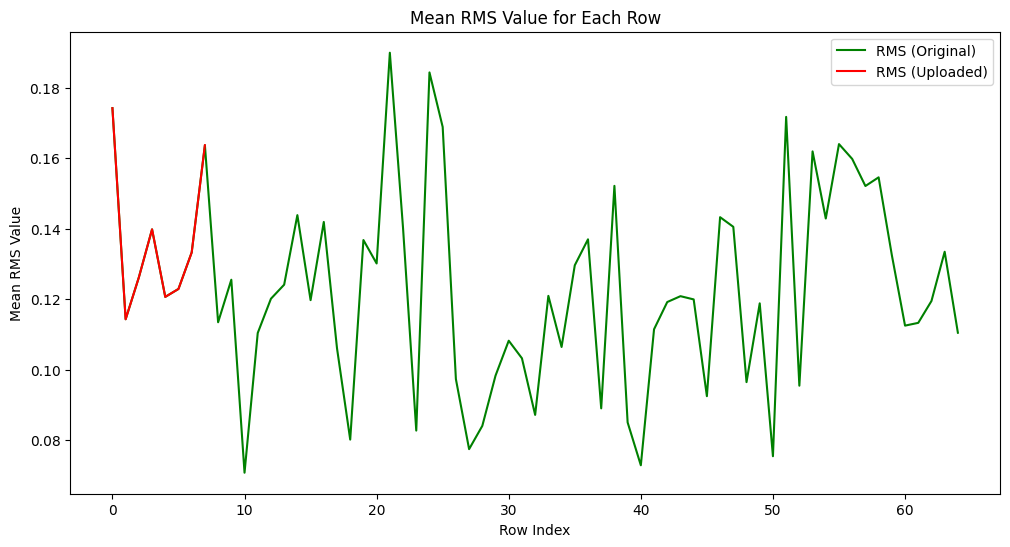

In [92]:
plot_rms_rows(rms_df_only, upload_df_only)

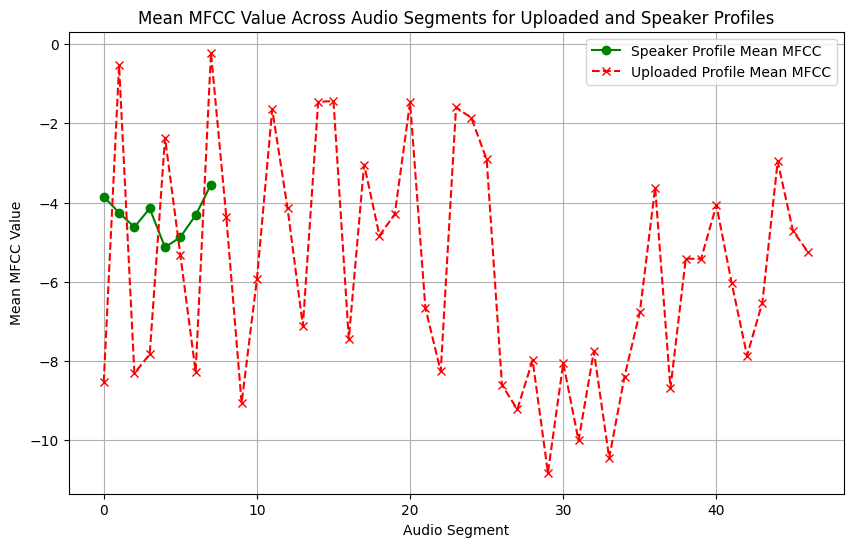

In [78]:
# Calculate the mean of MFCC features for each row in both DataFrames
mfcc_columns = [col for col in speaker_profile.columns if "mfcc_feature" in col]
speaker_profile["mfcc_mean"] = speaker_profile[mfcc_columns].mean(axis=1)
others_profile["mfcc_mean"] = others_profile[mfcc_columns].mean(axis=1)

# Plot the mean MFCC values across segments for both profiles
plt.figure(figsize=(10, 6))
plt.plot(speaker_profile.index, speaker_profile["mfcc_mean"], marker='o', linestyle='-', color='g', label="Speaker Profile Mean MFCC")
plt.plot(others_profile.index, others_profile["mfcc_mean"], marker='x', linestyle='--', color='r', label="Uploaded Profile Mean MFCC")

# Adding title and labels
plt.title("Mean MFCC Value Across Audio Segments for Uploaded and Speaker Profiles")
plt.xlabel("Audio Segment")
plt.ylabel("Mean MFCC Value")
plt.legend()
plt.grid()
plt.show()


In [ ]:
speaker_profile['label'] = 1
others_profile['label'] = 0

: 

In [84]:
speaker_profile

,file_name,mfcc_feature1,mfcc_feature2,mfcc_feature3,mfcc_feature4,mfcc_feature5,mfcc_feature6,mfcc_feature7,mfcc_feature8,mfcc_feature9,...,SpectralBandwidth79,SpectralBandwidth80,SpectralBandwidth81,SpectralBandwidth82,SpectralBandwidth83,SpectralBandwidth84,SpectralBandwidth85,SpectralBandwidth86,SpectralBandwidth87,label
0,synthetic\spanish86_cloned.mp3_segment_1,-231.127136,166.375809,-3.599792,15.212297,-20.045908,1.896581,-9.695123,-17.478123,-24.646132,...,781.309395,662.647208,586.730109,557.221521,574.270259,617.517023,692.035675,797.223058,2024.870537,1
1,synthetic\spanish86_cloned.mp3_segment_2,-246.181412,125.979584,-13.060126,46.474125,-10.591454,4.541656,-20.852091,-9.134948,-18.487989,...,2052.239604,2451.738891,2505.322709,2455.206579,1063.997178,862.433123,945.513280,1052.196497,1664.973759,1
2,synthetic\spanish86_cloned.mp3_segment_3,-271.776367,168.092285,-12.202765,4.581264,0.403620,-3.438253,-13.399918,-18.681316,-15.960804,...,817.597212,834.897795,757.724302,685.366678,779.418032,749.924679,800.196929,614.939932,2433.445562,1
3,synthetic\spanish86_cloned.mp3_segment_4,-263.963074,162.371109,-2.120367,22.425638,-0.110598,-10.114691,-16.552366,-16.638847,-23.304705,...,839.418996,995.699051,1485.813020,1857.091670,1430.845451,1497.716736,1808.671192,706.866682,1207.524052,1
4,synthetic\spanish86_cloned.mp3_segment_5,-279.814819,103.794708,-10.162716,51.620487,1.705923,5.315183,-18.408764,-6.782746,-18.879995,...,2105.165882,2398.075323,2339.669324,2150.252683,1423.174936,1507.962033,1428.697161,1438.596476,1592.437049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,synthetic\yidish3_cloned.mp3_segment_2,-192.034378,180.700287,-39.233883,29.109243,-10.784508,6.937807,-20.053219,1.526575,-10.205559,...,2084.383648,2217.903077,2157.239179,2165.914069,1646.643847,987.341104,928.335479,972.271912,1353.904191,1
61,synthetic\yidish3_cloned.mp3_segment_3,-190.227570,174.448090,-47.436520,33.034096,-5.642932,6.416922,-22.679394,5.441350,-20.702072,...,1135.985128,879.488598,852.646236,860.605592,842.063850,839.451937,752.737311,723.211253,1030.827507,1
62,synthetic\yidish3_cloned.mp3_segment_4,-183.592239,154.149399,-39.229340,35.502357,-8.292108,13.328004,-19.067837,3.176808,-22.203909,...,864.015225,872.588296,1032.984228,1561.184177,2247.594635,1093.753821,908.605700,817.552773,1395.537667,1
63,synthetic\yidish3_cloned.mp3_segment_5,-176.544266,164.458542,-48.430470,27.376707,-3.972572,11.599624,-24.351610,5.052410,-25.207127,...,803.049497,911.100983,1046.570969,1328.177102,1899.925172,2241.851143,2033.715734,1979.050474,2286.935749,1


In [23]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [95]:
data_df = pd.concat([speaker_profile, others_profile], ignore_index=True)
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [96]:
data_df

,file_name,mfcc_feature1,mfcc_feature2,mfcc_feature3,mfcc_feature4,mfcc_feature5,mfcc_feature6,mfcc_feature7,mfcc_feature8,mfcc_feature9,...,SpectralBandwidth79,SpectralBandwidth80,SpectralBandwidth81,SpectralBandwidth82,SpectralBandwidth83,SpectralBandwidth84,SpectralBandwidth85,SpectralBandwidth86,SpectralBandwidth87,label
0,synthetic\tagalog12_cloned.mp3_segment_1,-219.023972,105.023407,-16.943378,20.991636,-0.945665,7.347075,-16.004637,-16.177765,-25.826328,...,2941.602297,2910.752009,1715.501556,1552.244263,1259.303884,1254.379318,1166.315687,1123.796612,1677.609732,1
1,synthetic\turkish6_cloned.mp3_segment_1,-239.439850,129.939255,-12.233697,49.027523,9.448607,2.745888,1.585944,-0.403294,-10.599500,...,1193.415608,1128.085287,1050.177635,1092.796792,1073.852050,1354.749260,1132.512644,1120.918299,1291.733013,1
2,file10013.wav_16k.wav_norm.wav_mono.wav_silenc...,-213.605870,131.147960,-36.027584,33.928400,-45.672623,11.236031,-26.734375,-7.643105,-10.040931,...,1556.817711,1511.757361,1415.526670,1610.442123,1461.007826,1193.401414,1116.463812,1156.123729,1040.184604,0
3,tagalog4.mp3,-365.483340,82.784490,-2.731915,29.787891,1.853044,0.154799,-22.464176,-18.536942,-15.819559,...,1279.689499,1059.807153,1106.417610,1396.177589,2133.648894,2552.775912,2565.383559,2682.718588,2676.683766,0
4,synthetic\yidish3_cloned.mp3_segment_3,-190.227570,174.448090,-47.436520,33.034096,-5.642932,6.416922,-22.679394,5.441350,-20.702072,...,1135.985128,879.488598,852.646236,860.605592,842.063850,839.451937,752.737311,723.211253,1030.827507,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,file10003.wav_16k.wav_norm.wav_mono.wav_silenc...,-196.797910,143.789060,-29.306421,73.829100,26.663227,5.764907,-6.642285,5.408102,-20.332932,...,708.888848,644.192354,753.837025,1046.867774,1244.309927,1300.858221,1287.754754,1553.103221,2175.267948,0
108,synthetic\turkish6_cloned.mp3_segment_10,-264.105011,160.336166,-11.739163,38.362926,8.869956,3.533375,3.462703,5.496899,-15.027587,...,1067.716769,1442.660720,1647.626632,1549.321588,1366.013344,1144.603576,820.782217,828.953126,2317.134920,1
109,tagalog14.mp3,-305.217130,88.351520,0.525879,20.892130,-17.017250,-9.521770,-20.819426,-4.172087,-23.187962,...,1675.874286,1445.820973,1314.193411,1220.659248,1175.292421,1215.545079,1282.148458,1393.566196,2324.730380,0
110,synthetic\turkish6_cloned.mp3_segment_6,-252.326279,140.616226,-19.814943,34.701668,-1.491571,7.175479,-2.928121,4.329619,-14.625578,...,2706.575815,2856.439492,2438.117630,2146.246855,2222.772645,2083.404142,2054.264819,2071.660685,2323.858197,1


In [97]:
X = data_df.drop(columns=['file_name','label']).values
y = data_df['label'].values

y

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1], dtype=int64)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 42)

In [99]:
X_train

array([[-190.22756958,  174.4480896 ,  -47.43651962, ...,  752.73731133,
         723.21125317, 1030.82750657],
       [-247.8129425 ,  139.11691284,  -24.12085533, ..., 1832.4453342 ,
        1930.83643785, 2408.60663909],
       [-220.85591   ,  116.22963   ,  -29.867117  , ..., 1149.059443  ,
        1036.340992  , 1253.845142  ],
       ...,
       [-142.87376404,   67.14640808,  -40.60208893, ..., 1612.94845037,
        2402.82159607, 2210.05729881],
       [-195.64900208,  121.08058167,  -18.30451775, ..., 1173.76037786,
        1195.2364279 , 2272.372983  ],
       [-250.93049622,   80.76491547,    5.18104267, ..., 1171.29976193,
        1310.92335467, 2574.32084495]])

In [100]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

speaker_identification_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1],1,1), padding='same'),
    MaxPooling2D((2,1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2,1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

c:\Daren\University of the East\THESIS\Thesis-Project-version1\Thesis-Project-prototype\Thesis-Project-prototype\server\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [120]:
X_train.shape[1]

387

In [104]:
speaker_identification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
speaker_identification_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 387, 1, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 193, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 193, 1, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 96, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,537 (787.25 KB)

 Trainable params: 201,537 (787.25 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
sr_model = 0

In [106]:
history = speaker_identification_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)
speaker_identification_model.evaluate(X_test, y_test)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6306 - loss: 0.6827 - val_accuracy: 0.6818 - val_loss: 0.5848
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5946 - loss: 0.6782 - val_accuracy: 0.7727 - val_loss: 0.6296
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7243 - loss: 0.5897 - val_accuracy: 0.8182 - val_loss: 0.5326
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7557 - loss: 0.5506 - val_accuracy: 0.8636 - val_loss: 0.4937
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8348 - loss: 0.4372 - val_accuracy: 0.8182 - val_loss: 0.4742
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8722 - loss: 0.3968 - val_accuracy: 0.8182 - val_loss: 0.4394
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9023 - loss: 0.2994 - val_accuracy: 0.8182 - val_loss: 0.3878
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9538 - loss: 0.2727 - val_accuracy: 0.8636 - val_loss: 0.4448

[3.2143514156341553, 0.5]

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [107]:
sr_model = speaker_identification_model

In [108]:
si_scaler = joblib.load('scalers/vr_scaler.pkl')

c:\Daren\University of the East\THESIS\Thesis-Project-version1\Thesis-Project-prototype\Thesis-Project-prototype\server\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [114]:
file_2 = ['spanish86_cloned.mp3']

In [115]:
test_process = process_audio_segments(file_2)
si_segment_data = df_segment_data(*test_process)
si_segment_data_values = si_segment_data.drop(columns=['file_name']).values
confidence_scores = evaluate_segments(si_segment_data_values, sr_model, si_scaler)
overall = average(confidence_scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [116]:
sr_model.input_shape

(None, 387, 1, 1)

In [117]:
si_segment_data_values.shape

(8, 387)

In [118]:
overall

0.9999782219529152